The tutorial for neural network training

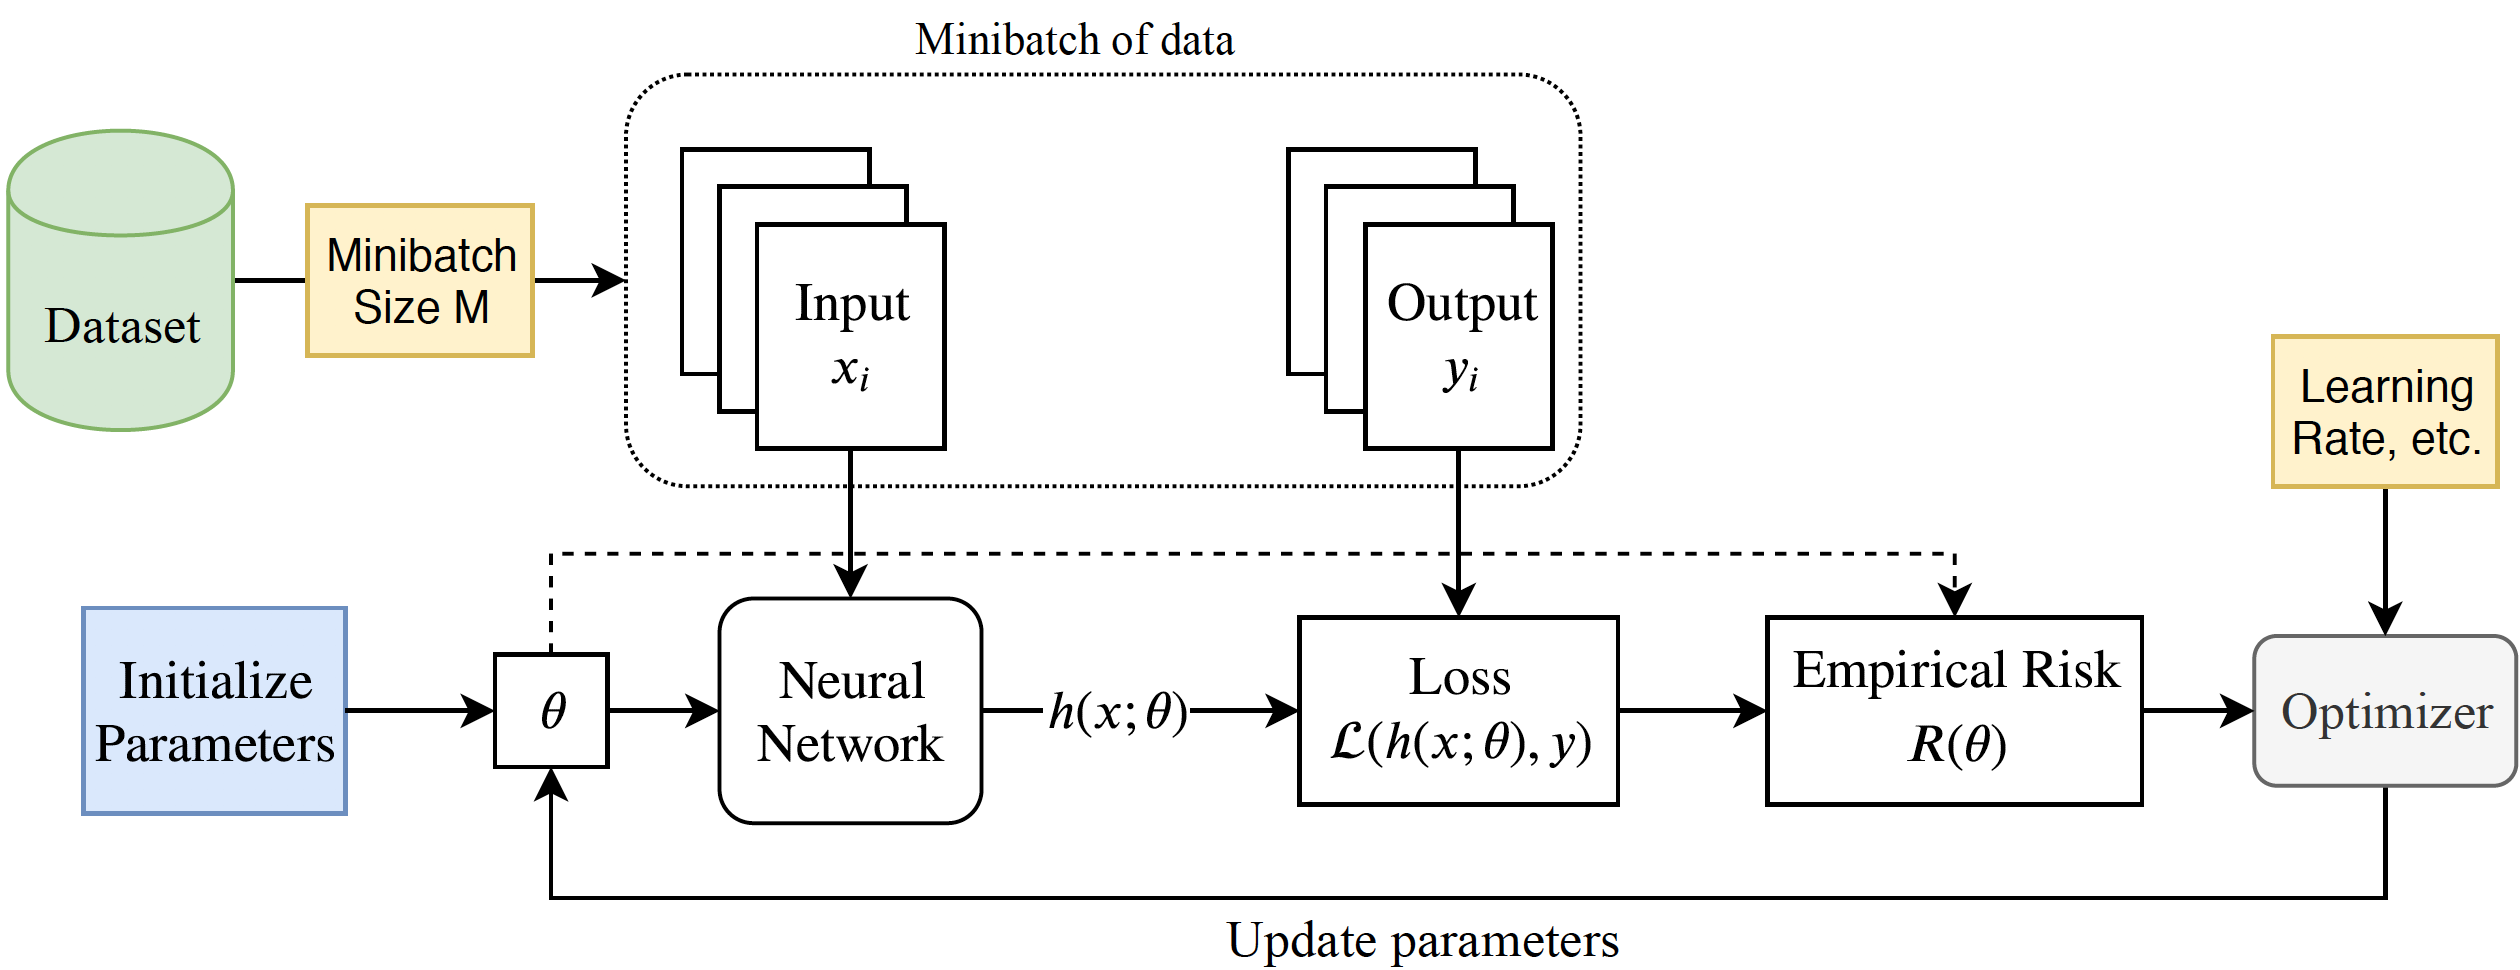

Preparation:
    - normalize data
    - data augmentations
    - define model, loss function, optimizer, initialize model params
    - loop until some stopping criteria is met:
        - smaple amini batch of data as inputs
        - compute the forward pass of teh model with the inputs
        - compute the cost function on model predictions and labels
        - update model params using optimizer
    - tune hyperparams like leraning rate, batch size, number of training epochs

Import libraries

In [1]:
%matplotlib inline

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.utils.data as data

import torchvision.transforms as transforms
import torchvision.datasets as datasets

from tqdm.notebook import trange, tqdm
import matplotlib.pyplot as plt
import numpy as np

import copy
import random
import time

Reproducibility

In [2]:
seed = 42

random.seed(42)
np.random.seed(42)
torch.manual_seed(42)
torch.cuda.manual_seed(42)
torch.backends.cudnn.deterministic=True

MNIST dataset

In [3]:
train_data = datasets.MNIST(root='data', train=True, download=True)
test_data = datasets.MNIST(root='data', train=False, download=True)

print(f"Number of training examples {len(train_data)}")
print(f"Number of testing examples {len(train_data)}")

Number of training examples 60000
Number of testing examples 60000


Normalizing the data

In [4]:
# Division by 255 stems from images being int8 ?
mean = train_data.data.float().mean() / 255
std = train_data.data.float().mean() / 255

print(f"""
Calculated mean {mean}
Calculated std {std}""")

data_transforms = transforms.Compose(
    [
        transforms.ToTensor(),
        transforms.Normalize(mean=[mean], std=[std])
    ]
)

train_data = datasets.MNIST(root='.data', train=True, download=True, transform=data_transforms)

test_data = datasets.MNIST(root='.data', train=False, download=True, transform=data_transforms)


Calculated mean 0.13066047430038452
Calculated std 0.13066047430038452


Plot images

In [5]:
# def plot_images(images, labels):

#     n_images = len(images)

#     rows = int(np.sqrt(n_images))
#     cols = int(np.sqrt(n_images))

#     fig = plt.figure(figsize=(10,10))
#     for i in range(rows*cols):
#         ax = fig.add_subplot(rows, cols, i+1)
#         ax.imshow(images[i].view(28, 28).cpu().numpy(), cmap='bone')
#         ax.set_title(f'label: {labels[i]}')
#         ax.axis('off')

# N_IMAGES = 0
# images = [image for image, label in [train_data[i] for i in range(N_IMAGES)]]
# labels = [label for image, label in [train_data[i] for i in range(N_IMAGES)]]
# plot_images(images, labels)

Model definition

In [8]:
class FCNet_ZeroInit(nn.Module):
    def __init__(self, input_dim, output_dim):

        super().__init__()

        # 3 layer fully connected network
        self.input_fc = nn.Linear(input_dim, 128)
        self.hidden_fc = nn.Linear(128, 100)
        self.output_fc = nn.Linear(100,output_dim)

        # Initializa weights and biases to zero : unstable
        nn.init.zeros_(self.input_fc.weight)
        nn.init.zeros_(self.hidden_fc.weight)
        nn.init.zeros_(self.output_fc.weight)

        nn.init.zeros_(self.input_fc.bias)
        nn.init.zeros_(self.hidden_fc.bias)
        nn.init.zeros_(self.output_fc.bias)

    def forward(self, x):

        batch_size = x.shape[0]
        x = x.view(batch_size, -1)

        h_1 = self.input_fc(x)
        h_2 = self.hidden_fc(h_1)

        y_pred = self.output_fc(h_2)

        # Usually just return predictions but activations are helpful for diagnostics
    
        return y_pred, h_2

    
input_dim = 28*28
output_dim = 10

model = FCNet_ZeroInit(input_dim, output_dim)


Counting parameters that require gradients (try analitically)

In [11]:
def count_params(model):
    return sum(p.numel()for p in model.parameters() if p.requires_grad)

print(f"The model has {count_params(model):,} trainable parameters")

The model has 114,390 trainable parameters


Model training

In [12]:
def calculate_accuracy(y_pred, y):
    top_pred = y_pred.argmax(1, keepdim=True)
    correct = top_pred.eq(y.view_as(top_pred)).sum()
    acc = correct.float() / y.shape[0]

    return acc

def train(model, iterator, optimizer, criterion, device):
    epoch_loss = 0
    epoch_acc = 0

    # Set the model in training model
    model.train()

    # Sample a mini batch
    for (x,y) in tqdm(iterator, desc='Training', leave=False):
        x = x.to(device)
        y = y.to(device)

        # Zero out all the gradients tracked by the optimizer
        optimizer.zero_grad()

        # Run the forward pass: under the hood, this calls your model's forward function
        y_pred, _ = model(x)

        # Compute the loss
        loss = criterion(y_pred, y)

        # Calculate training accuracy on this batch
        acc = calculate_accuracy(y_pred, y )

        # Backpropagate gradients of the loss wrt parameters
        loss.backward()
        
        # Update the network params
        optimizer.step()

        # Track the training loss
        epoch_loss += loss.item()

        # Tracck training accuracy
        epoch_acc += acc.item()


    # Return average loss and accuracy per batch
    return epoch_loss / len(iterator), epoch_acc / len(iterator)


def evaluate(model, iterator, criterion, device):

    epoch_loss = 0
    epoch_acc = 0

    model.eval()

    # Don't compute gradients since we won't update the model during evaluation
    for (x,y) in tqdm(iterator, desc='Evaluating', leave=False):
        x = x.to(device)
        y = y.to(device)

        y_pred, _ = model(x)

        loss = criterion(y_pred, y)

        acc = calculate_accuracy(y_pred, y)

        epoch_loss += loss.item()
        epoch_acc = acc.item()

    return epoch_loss/len(iterator), epoch_acc/len(iterator)

Define the whole workflow

In [15]:
lr = 0.01
epochs = 10
batch_size = 32

train_iterator = data.DataLoader(train_data, shuffle=True, batch_size=batch_size)

def run(model, train_iterator, epochs, lr):

    optimizer = optim.Adam(model.parameters(), lr=lr)

    criterion = nn.CrossEntropyLoss()

    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    model = model.to(device)
    criterion = criterion.to(device)

    for epoch in range(epochs):
        train_loss, train_acc = train(model, train_iterator, optimizer, criterion, device)

        print(f"Epoch: {epoch+1:02}")
        print(f"\t Train loss: {train_loss:.3f} | Train acc: {train*100:.2f}%")

run(model, train_iterator, epochs, lr)


ImportError: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html

Diagnosing the model

In [ ]:
def get_representations(model, iterator):

    model.eval()
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    outputs = []
    intermediates = []
    labels = []

    with torch.no_grad()

    for (x,y) in tqdm(iterator):

        x=x.to(device)

        y_pred, h = model(x)

        outputs.append(y_pred.cpu())

        intermediates.append(h.cpu())

        labels.append(y)


    ouputs = torch.cat(outputs, dim=0)
    intermediates = torch.cat(intermediates, dim=0)
    labels = torch.cat(labels, dim=0)

    return outputs, intermediates, labels

outputs, intermediates, labels = get_representations(model, train_iterator)

Plot histogram: we can see that every single data point is assigned the exact same prediction probability when plotting outputs.

def plot_hist(data_to_plot):
    num_dimensions = data_to_plot.shape[1]
    fig = plt.figure(figsize=(8, 10))
    for i in range(num_dimensions):
        ax = fig.add_subplot(num_dimensions // 2, 2, i+1)
        dimension_data = data_to_plot[:, i].cpu().detach().numpy()
        ax.hist(dimension_data, bins=50)
        ax.set_title(f'Dimension {i}')
        ax.set_xlabel('Value')
        ax.set_ylabel('Frequency')

    plt.tight_layout()
    plt.show()

plot_hist(outputs)

Plot histogram of intermediats: all actiavtions are zero no matter the input! This is because of zero initialization.

In [ ]:
plot_hist(intermediates[:, :10])

Define the model: pytorch initiates the params using random values so we shouldn't override this settings

In [ ]:
class FCNet(nn.Module):
    def __init__(self, input_dim, output_dim):
        super().__init__()

        self.input_fc = nn.Linear(input_dim, 128)
        self.hidden_fc = nn.Linear(128, 100)
        self.output_fc = nn.Linear(100, output_dim)

    def forward(self, x):
        # x = [batch size, height, width]

        batch_size = x.shape[0]
        x = x.view(batch_size, -1)
        # x = [batch size, height * width]

        h_1 = F.relu(self.input_fc(x))
        # h_1 = [batch size, 250]

        h_2 = F.relu(self.hidden_fc(h_1))
        # h_2 = [batch size, 100]

        y_pred = self.output_fc(h_2)
        # y_pred = [batch size, output dim]

        return y_pred, h_2

model = FCNet(INPUT_DIM, OUTPUT_DIM)
print(f'The model has {count_parameters(model):,} trainable parameters')

run(model, train_iterator, EPOCHS, LR)

Train - validation - test split

In [ ]:
VALID_RATIO = 0.9

n_train_examples = int(len(train_data) * VALID_RATIO)
n_valid_examples = len(train_data) - n_train_examples

train_data, valid_data = data.random_split(train_data,
                                           [n_train_examples, n_valid_examples])

print(f'Number of training examples: {len(train_data)}')
print(f'Number of validation examples: {len(valid_data)}')
print(f'Number of testing examples: {len(test_data)}')

train_iterator = data.DataLoader(train_data,
                                 shuffle=True,
                                 batch_size=BATCH_SIZE)

valid_iterator = data.DataLoader(valid_data,
                                 batch_size=BATCH_SIZE)

test_iterator = data.DataLoader(test_data,
                                batch_size=BATCH_SIZE)

Early stopping

In [ ]:
def run(model, train_iterator, valid_iterator, test_iterator, epochs, lr):

  optimizer = optim.Adam(model.parameters(), lr=lr)
  criterion = nn.CrossEntropyLoss()
  device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

  model = model.to(device)
  criterion = criterion.to(device)

  best_valid_loss = float('inf')

  for epoch in trange(epochs):

      train_loss, train_acc = train(model, train_iterator, optimizer, criterion, device)
      valid_loss, valid_acc = evaluate(model, valid_iterator, criterion, device)

      if valid_loss < best_valid_loss:
          best_valid_loss = valid_loss
          torch.save(model.state_dict(), 'best-model.pt')

      print(f'Epoch: {epoch+1:02}')
      print(f'\tTrain Loss: {train_loss:.3f} | Train Acc: {train_acc*100:.2f}%')
      print(f'\t Val. Loss: {valid_loss:.3f} |  Val. Acc: {valid_acc*100:.2f}%')

  model.load_state_dict(torch.load('best-model.pt', weights_only=True))
  test_loss, test_acc = evaluate(model, test_iterator, criterion, device)

  print(f'Test Loss: {test_loss:.3f} | Test Acc: {test_acc*100:.2f}%')

model = FCNet(INPUT_DIM, OUTPUT_DIM)
run(model, train_iterator, valid_iterator, test_iterator, EPOCHS, LR)

MLP with ReLu

class MLP(nn.Module):
    def __init__(self, input_dim, output_dim):
        super().__init__()

        self.input_fc = nn.Linear(input_dim, 128)
        self.hidden_fc = nn.Linear(128, 100)
        self.output_fc = nn.Linear(100, output_dim)

    def forward(self, x):
        # x = [batch size, height, width]

        batch_size = x.shape[0]
        x = x.view(batch_size, -1)
        # x = [batch size, height * width]

        h_1 = F.relu(self.input_fc(x))
        # h_1 = [batch size, 250]

        h_2 = F.relu(self.hidden_fc(h_1))
        # h_2 = [batch size, 100]

        y_pred = self.output_fc(h_2)
        # y_pred = [batch size, output dim]

        return y_pred, h_2

model = MLP(INPUT_DIM, OUTPUT_DIM)
print(f'The model has {count_parameters(model):,} trainable parameters')

run(model, train_iterator, valid_iterator, test_iterator, EPOCHS, LR)

Modifying the learning rate: perform grid search over some set of values

LR = 1e-3

model = MLP(INPUT_DIM, OUTPUT_DIM)
run(model, train_iterator, valid_iterator, test_iterator, EPOCHS, LR)

Batch normalization

Optimizers: SGD, RMSProp and what's the best learning rate for each optimizer?